In [1]:
"""OpenNeuro Datasets Analyses."""

'Data inspection.'

In [31]:
import glob
import logging
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import nibabel
import os
import sklearn

from joblib import Parallel, delayed

import torch
import numpy as np
import pickle
from ipywidgets import interact, interactive, fixed, interact_manual, IntSlider, FloatSlider
import ipywidgets as widgets
import importlib

import vis
importlib.reload(vis)

import warnings
warnings.filterwarnings("ignore")

NEUROPATH = '/neuro/train_val_datasets'
OUTPUT_DIR = '/scratch/users/nmiolane/output'
DEVICE='cuda'

EPOCH_ID = 0
LATENT_DIM = 50

DATASET = 'ds000174'

ModuleNotFoundError: No module named 'skimage'

# Get data

In [ ]:
process_dir = '/neuro/preprocessed_saved/img_51.nii.gz'

(192, 256, 256)


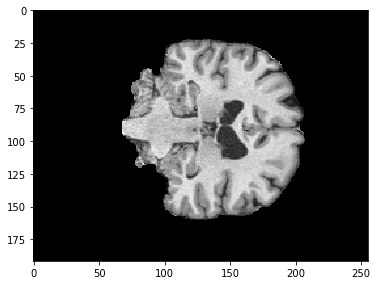

In [58]:
#one_path = '/neuro/t1scans/ds000174/sub-211/ses-BL/anat/sub-211_ses-BL_T1w.nii.gz'
one_path = '/neuro/preprocessed_saved/img_274.nii.gz'

one_img = nibabel.load(one_path)
print(one_img.shape)
array = one_img.get_fdata()
array = np.nan_to_num(array)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(array[:, 128, :], cmap='gray')

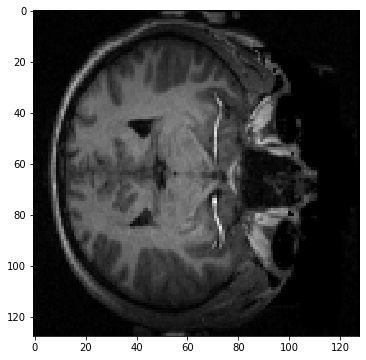

In [67]:
path = '/neuro/train_val_datasets/val_mri_128x128.npy'
val = np.load(path)
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(val[5, 0, :, :], cmap='gray')

In [38]:

def is_diag(M):
    return np.all(M == np.diag(np.diagonal(M)))


def affine_matrix_permutes_axes(affine_matrix):
    mat = affine_matrix[:3, :3]
    if not is_diag(mat):
        print('not diagonal, skipping')
        return True
    if np.any(mat < 0):
        print('negative values, skipping')
        return True
    return False

In [39]:
def process_nii(target_dir, path):
    logging.info('Loading image %s...', path)
    img = nibabel.load(path)

    if affine_matrix_permutes_axes(img.affine):
        print('Skip image %s - bad affine orientation' % path)
        return

    array = img.get_fdata()
    array = np.nan_to_num(array)
    std = np.std(array.reshape(-1))
    array = array / std
    mean = np.mean(array.reshape(-1))
    # HACK Alert
    # This is a way to check if the backgound is a white noise.
    if mean > 1.0:
        print('Skip image %s - mean too high: %s' % (path, mean))
        return
    
    array = skimage.transform.resize(array, IMG_SHAPE)
    output.append(array)
    
    if len(array.shape) != 4:
        # Adding channels
        array = np.expand_dims(array, axis=0)
    img = array[:, :, :, 3]
    output.append(img)
    
    img_path = os.path.join(target_dir, os.path.basename(path))
    np.save(img_path, img)

In [40]:
data_dir = '/neuro/t1scans/ds000174'
filepaths = glob.glob(data_dir + '/**/*.nii.gz', recursive=True)
print(len(filepaths))
target_dir = '/neuro/ds000171_processed/'

processed_filepaths = []
Parallel(backend="threading", n_jobs=4)(delayed(process_nii)(
    target_dir, path)
    for path in filepaths)

84
not diagonal, skipping
Skip image /neuro/t1scans/ds000174/sub-101/ses-FU/anat/sub-101_ses-FU_T1w.nii.gz - bad affine orientation
not diagonal, skipping
Skip image /neuro/t1scans/ds000174/sub-101/ses-BL/anat/sub-101_ses-BL_T1w.nii.gz - bad affine orientation
not diagonal, skipping
Skip image /neuro/t1scans/ds000174/sub-103/ses-FU/anat/sub-103_ses-FU_T1w.nii.gz - bad affine orientation
not diagonal, skippingnot diagonal, skipping
Skip image /neuro/t1scans/ds000174/sub-103/ses-BL/anat/sub-103_ses-BL_T1w.nii.gz - bad affine orientation

Skip image /neuro/t1scans/ds000174/sub-104/ses-BL/anat/sub-104_ses-BL_T1w.nii.gz - bad affine orientation
not diagonal, skipping
Skip image /neuro/t1scans/ds000174/sub-104/ses-FU/anat/sub-104_ses-FU_T1w.nii.gz - bad affine orientation
not diagonal, skipping
Skip image /neuro/t1scans/ds000174/sub-108/ses-BL/anat/sub-108_ses-BL_T1w.nii.gz - bad affine orientation
not diagonal, skipping
Skip image /neuro/t1scans/ds000174/sub-109/ses-BL/anat/sub-109_ses-BL_T

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

# 1. Inspect chosen VAE Model

### Inspect training

In [13]:
vis.plot_losses(OUTPUT_DIR, epoch_id=EPOCH_ID)

KeyError: 'train'

In [14]:
vis.show_samples_from_prior(OUTPUT_DIR, epoch_id=EPOCH_ID, latent_dim=latent_dim)

Loading: /scratch/users/nmiolane/output0227_128x128/training/models/epoch_115_decoder_train_loss_4477.2652_test_loss_4707.6995.pth


/home/user/miniconda/envs/py36/lib/python3.6/site-packages/torch/serialization.py:454: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ReLU' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/user/miniconda/envs/py36/lib/python3.6/site-packages/torch/serialization.py:454: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/user/miniconda/envs/py36/lib/python3.6/site-packages/torch/serialization.py:454: SourceChangeWarning: source code of class 'torch.nn.modules.upsampling.UpsamplingNearest2d' has changed. you can retrieve the

AttributeError: 'Conv2d' object has no attribute 'padding_mode'

# 2. Inspect the latent space

## Standard PCA on the means of the approximation of the posterior

### Load test set and compute latent codes

In [49]:
from sklearn.decomposition import PCA
N_COMPONENTS = 5

# epoch_id = 120
# encoder = load_model('encoder', epoch_id)

encoder = load_last_model('encoder')

test = np.load(f'{directory}/test_img_64x64.npy')

test = torch.Tensor(test)
test_dataset = torch.utils.data.TensorDataset(test)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=1, shuffle=True)

Last checkpoint:  /scratch/users/nmiolane/output/training/models/epoch_1_encoder_train_loss_3.0822_test_loss_0.4409.pth


In [50]:
# Euclidean PCA on the Gaussian means learnt by the model
mus = []
for i, data in enumerate(test_loader):
    data = data[0].to(DEVICE)
    mu, logvar = encoder(data)
    mus.append(np.array(mu.cpu().detach()))

mus = np.array(mus).squeeze()
print(mus.shape)

pca = PCA(n_components=N_COMPONENTS)
pca.fit(mus)
print(mus.shape)
projected_mus = pca.transform(mus)
print(mus.shape)

(76, 50)
(76, 50)
(76, 50)


## Gaussian Kernel Density Estimation

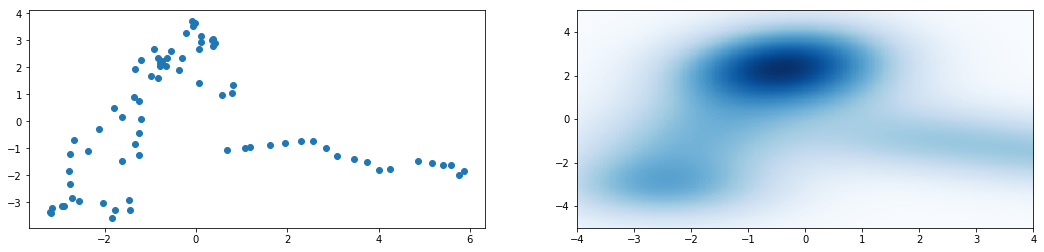

In [51]:
from scipy.stats import gaussian_kde


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 4))
ax = axes[0]
ax.scatter(projected_mus[:, 0], projected_mus[:, 1])

ax = axes[1]

x = projected_mus[:, 0]
y = projected_mus[:, 1]
data = np.vstack([x, y])
kde = gaussian_kde(data)

# evaluate on a regular grid
xgrid = np.linspace(-4, 4, 200)
ygrid = np.linspace(-5, 5, 200)
Xgrid, Ygrid = np.meshgrid(xgrid, ygrid)
Z = kde.evaluate(np.vstack([Xgrid.ravel(), Ygrid.ravel()]))

# Plot the result as an image
ax.imshow(Z.reshape(Xgrid.shape),
           origin='lower', aspect='auto',
           extent=[-4, 4, -5, 5],
           cmap='Blues')
#cb = plt.colorbar()
#cb.set_label("density")

# for i in range(N_COMPONENTS):
#    mus = projected_mus[:,i]
#    print(np.std(mus))
#    plt.subplot(n_rows, n_cols, i+3)
#    plt.hist(mus, bins='auto')


## Fit a Gaussian Mixture

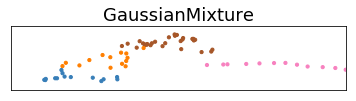

In [52]:
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

# Clustering
X = projected_mus
n_components = 5

#X = StandardScaler().fit_transform(X)
gmm = mixture.GaussianMixture(
    n_components=n_components, covariance_type='full')
algorithm = gmm
name = 'GaussianMixture'
    
algorithm.fit(X)

if hasattr(algorithm, 'labels_'):
    print('test')
    y_pred = algorithm.labels_.astype(np.int)
else:
    y_pred = algorithm.predict(X)

plt.subplot(n_rows, n_cols, 3)
plt.title(name, size=18)

colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                     '#f781bf', '#a65628', '#984ea3',
                                      '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
# add black color for outliers (if any)
colors = np.append(colors, ["#000000"])
plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

plt.xlim(-4, 4)
plt.ylim(-5, 5)
plt.xticks(())
plt.yticks(())

plt.show()

### Interactive exploration of PCA in each cluster

In [54]:
print(torch.__version__)

1.0.0


In [53]:
epoch_id = 1

stds = np.zeros(N_COMPONENTS)
for i in range(N_COMPONENTS):
    stds[i] = np.std(projected_mus[:,i])
    
decoder = load_model('decoder', epoch_id)


projected = {}
pcas = {}
for i in range(n_components):
    print('Cluster: %d' % i)
    cluster = mus[y_pred==i]
    pca = PCA(n_components=N_COMPONENTS)
    pca.fit(cluster)
    projected[i] = pca.transform(cluster)
    pcas[i] = pca

    @interact(
        c1=FloatSlider(min=-3,max=3,step=0.1,value=0), 
        c2=FloatSlider(min=-3,max=3,step=0.1,value=0),
        c3=FloatSlider(min=-3,max=3,step=0.1,value=0),
        c4=FloatSlider(min=-3,max=3,step=0.1,value=0),
        c5=FloatSlider(min=-3,max=3,step=0.1,value=0))
    def display_image(c1, c2, c3, c4, c5):
        z = (c1 * pca.components_[0]
             + c2 * pca.components_[1]
             + c3 * pca.components_[2]
             + c4 * pca.components_[3]
             + c5 * pca.components_[4])
        z = torch.Tensor(z).cuda()
        recon, _ = decoder(z)
        recon = recon.squeeze()
        plt.imshow(recon.detach().cpu(), cmap='afmhot')

Loading: /scratch/users/nmiolane/output/training/models/epoch_1_decoder_train_loss_3.0822_test_loss_0.4409.pth
Cluster: 0


interactive(children=(FloatSlider(value=0.0, description='c1', max=3.0, min=-3.0), FloatSlider(value=0.0, desc…

Cluster: 1


interactive(children=(FloatSlider(value=0.0, description='c1', max=3.0, min=-3.0), FloatSlider(value=0.0, desc…

Cluster: 2


interactive(children=(FloatSlider(value=0.0, description='c1', max=3.0, min=-3.0), FloatSlider(value=0.0, desc…

Cluster: 3


interactive(children=(FloatSlider(value=0.0, description='c1', max=3.0, min=-3.0), FloatSlider(value=0.0, desc…

Cluster: 4


interactive(children=(FloatSlider(value=0.0, description='c1', max=3.0, min=-3.0), FloatSlider(value=0.0, desc…

### PCA in each cluster

Cluster: 0


/home/user/miniconda/envs/py36/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.UpsamplingNearest2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


Cluster: 1


/home/user/miniconda/envs/py36/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.UpsamplingNearest2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


Cluster: 2


/home/user/miniconda/envs/py36/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.UpsamplingNearest2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


Cluster: 3


/home/user/miniconda/envs/py36/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.UpsamplingNearest2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


Cluster: 4


/home/user/miniconda/envs/py36/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.UpsamplingNearest2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


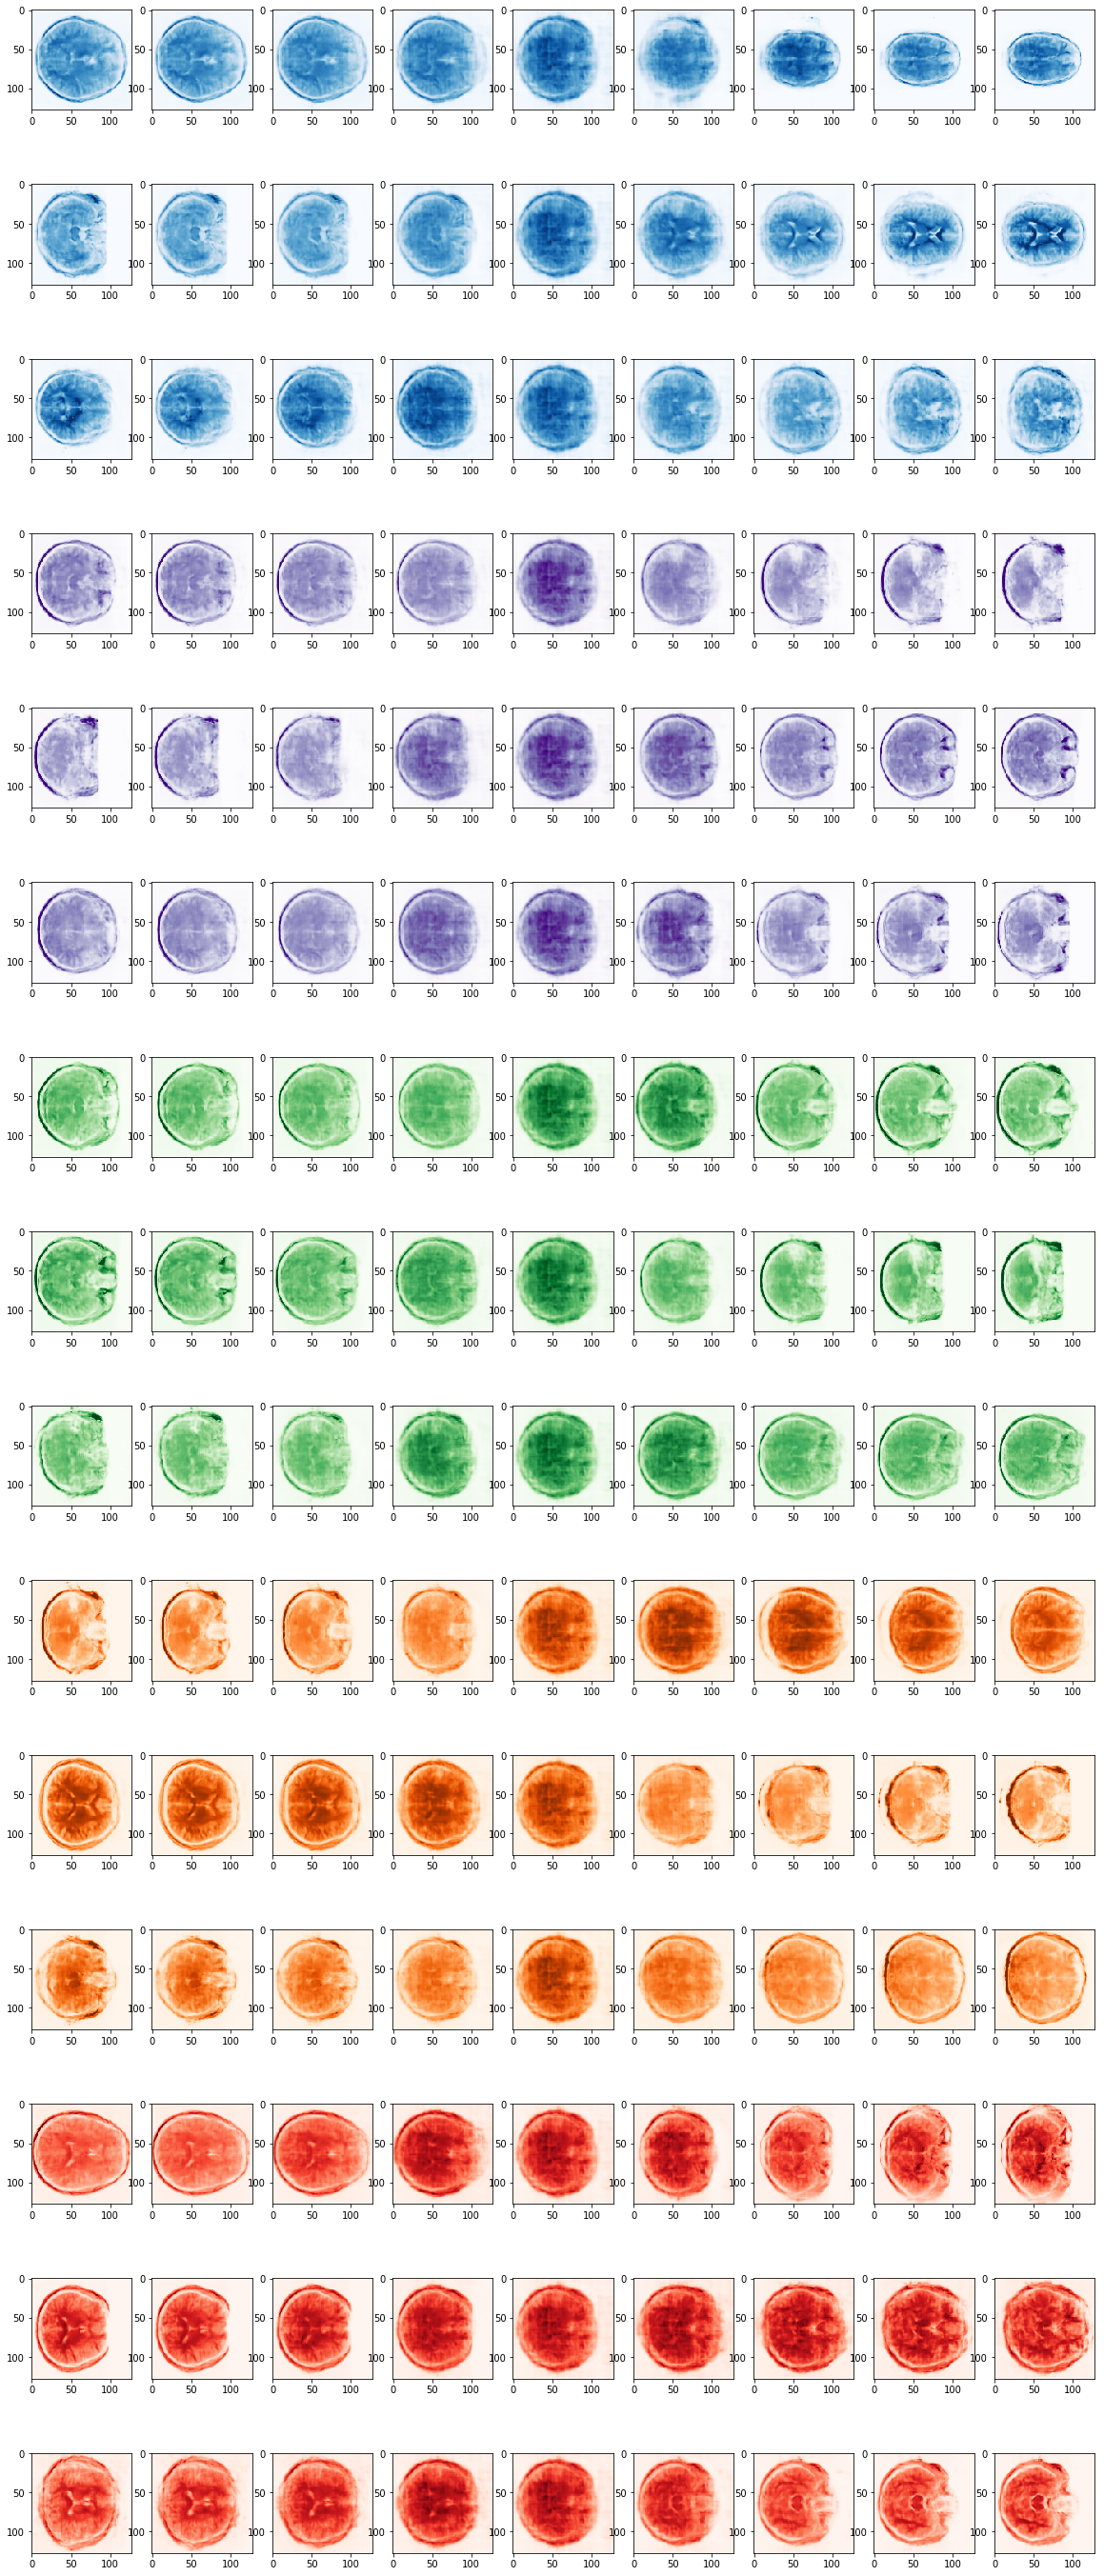

In [60]:
fig = plt.figure(figsize=(20, 50))
plt.tight_layout()
r = 4
n_cols = 2 * r + 1 

projected = {}
pcas = {}
cmaps = ['Blues', 'Purples', 'Greens', 'Oranges', 'Reds']
for i in range(n_clusters):
    cluster = mus[y_pred==i]
    pca = PCA(n_components=N_COMPONENTS)
    pca.fit(cluster)
    projected[i] = pca.transform(cluster)
    pcas[i] = pca

    for id in range(N_COMPONENTS):
        for slider in range(-r, r+1, 1):
            plt.subplot(n_clusters*N_COMPONENTS, n_cols, i * N_COMPONENTS * n_cols + id * n_cols + slider + r + 1)
            z = slider * pca.components_[id]
            z = torch.Tensor(z).cuda()
            recon, _ = decoder(z)
            recon = recon.squeeze()
            plt.imshow(recon.detach().cpu(), cmap=cmaps[i])

# 3. Inspect report created by pipeline

In [49]:
import os
import pylab

report_dir = '/scratch/users/nmiolane/output/report'
losses_path = os.path.join(report_dir, 'losses.png')
images_path = os.path.join(report_dir, 'images.png')
report_path = os.path.join(report_dir, 'report.html')

plt.figure()
img = pylab.imread(losses_path)
plt.imshow(img, aspect='auto')
plt.axis('off')

plt.figure(figsize=(30, 60))
img = pylab.imread(images_path)
plt.imshow(img)
plt.axis('off')


FileNotFoundError: [Errno 2] No such file or directory: '/scratch/users/nmiolane/output/report/losses.png'

<Figure size 432x288 with 0 Axes>

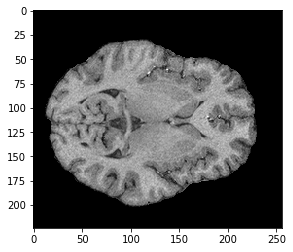

In [3]:
import nibabel
path = '/tmp/_oyiw_36_defBrainExtractionBrain.nii.gz'
img = nibabel.load(path)
array = img.get_fdata()
array = np.nan_to_num(array)
plt.imshow(array[:,:,120], cmap='gray')